In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold
from sklearn.multiclass import OneVsOneClassifier
import time
import pickle

In [2]:
root = "../../../../../"

In [3]:
df = pd.read_csv(root + "datasets/multiclass/processed/CICDDoS_pre.csv", index_col=[0])

In [4]:
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
10431,1,2,0,2736.0,0.0,1368.0,1368.0,1368.0,0.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
13090,1,2,0,2650.0,0.0,1325.0,1325.0,1325.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
12990,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
19624,46,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
20691,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS


In [5]:
X = df.drop(columns=[' Label'])
y = df[' Label']

In [6]:
input_features = len(X.columns)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42, stratify=y)

___
# Remove constant and quasi-constant features based on the training set

In [8]:
start = time.time()
# Feature Selection
fs_start = time.time()
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train)

features_to_keep = X.columns[selector.get_support()]

X_train = selector.transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test = selector.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = features_to_keep

X_train.drop(columns=' Fwd Header Length.1', inplace=True)
X_test.drop(columns=' Fwd Header Length.1', inplace=True)
fs_end = time.time()

___
# Training a model

In [9]:
# Training the model
train_start = time.time()
clf_xgb = xgb.XGBClassifier(eval_metric="logloss", seed=42)
# clf_xgb.fit(X_train, 
#             y_train,
#             # verbose=True,
#             ## the next three arguments set up early stopping.
#             early_stopping_rounds=5,
#             eval_metric='logloss',
#             eval_set=[(X_test, y_test)])
ovo = OneVsOneClassifier(clf_xgb)
#clf_xgb.fit(X_train, y_train)
ovo.fit(X_train, y_train)
train_end = time.time()
end = time.time()

c:\Users\pedro\miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\pedro\miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\pedro\miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of 

In [10]:
fs_time = (fs_end - fs_start)
train_time = (train_end - train_start)
fit_time = (end - start)

In [11]:
output_features = len(X_train.columns)

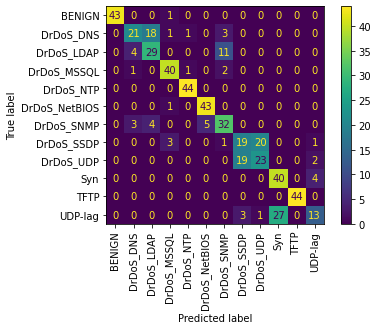

In [12]:
plot_confusion_matrix(ovo, 
                      X_test.values,
                      y_test,
                      values_format='d',
                      xticks_rotation='vertical')
plt.savefig(root + 'pictures/multiclass_one_vs_one/label_independent/confusion_matrix_basic.pdf', bbox_inches='tight')

In [13]:
y_pred = ovo.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average='macro')
f1score = f1_score(y_test, y_pred, average='macro')

In [14]:
pfm = pd.DataFrame(["Basic_Methods", accuracy, precision, recall, f1score,
                    fit_time, fs_time, train_time, input_features, output_features])
pfm = pfm.T
pfm.columns = ["Method", "Accuracy", "Precision", "Recall", "F1_Score", 
                "Fit_Time", "FS_Time", "Train_Time", "Input_Features", "Output_Features"]

filename = root + "pickles/multiclass_one_vs_one/hold_out/label_independent/basic.pkl"
outfile = open(filename, 'wb')
pickle.dump(pfm, outfile)
outfile.close()

In [15]:
print(classification_report(y_test, y_pred, digits=6))

               precision    recall  f1-score   support

       BENIGN   1.000000  0.977273  0.988506        44
    DrDoS_DNS   0.724138  0.477273  0.575342        44
   DrDoS_LDAP   0.568627  0.659091  0.610526        44
  DrDoS_MSSQL   0.869565  0.909091  0.888889        44
    DrDoS_NTP   0.956522  1.000000  0.977778        44
DrDoS_NetBIOS   0.895833  0.977273  0.934783        44
   DrDoS_SNMP   0.653061  0.727273  0.688172        44
   DrDoS_SSDP   0.463415  0.431818  0.447059        44
    DrDoS_UDP   0.522727  0.522727  0.522727        44
          Syn   0.597015  0.909091  0.720721        44
         TFTP   1.000000  1.000000  1.000000        44
      UDP-lag   0.650000  0.295455  0.406250        44

     accuracy                       0.740530       528
    macro avg   0.741742  0.740530  0.730063       528
 weighted avg   0.741742  0.740530  0.730063       528

